In [146]:
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

## Read csvs
train_df = pd.read_csv('train.csv', index_col=0)
test_df = pd.read_csv('test.csv', index_col=0)


Q1 = train_df.quantile(0.25)
Q3 = train_df.quantile(0.75)
IQR = Q3 - Q1

train_df = train_df[~((train_df < (Q1 - 1.5 * IQR)) |(train_df > (Q3 + 5 * IQR))).any(axis=1)].reset_index()
#train_df.shape

#Drop Duplicates

#Not sure is a good idea
#train_df.drop_duplicates(keep=False,inplace=True)
#test_df.drop_duplicates(keep=False,inplace=True)


print(train_df.shape,test_df.shape)






#FILTER OUTLIERS
#urls<350    PLUS STRICT 150
#images<85   PLUS STRICT 30
#chars_in_subject<300  PLUS STRICT 120
#chars_in_body<20000000  PLUS STRICT 130000

#train_df_urls = train_df[train_df.urls <= 350]
#train_df_images = train_df_urls[train_df_urls.images <= 85]
#train_df_subject = train_df_images[train_df_images.chars_in_subject <= 300]
#train_df_body = train_df_subject[train_df_subject.chars_in_body <= 1000000]
#train_df=train_df_body.reset_index()
#print(train_df.shape)

#train_df.urls.loc[train_df.urls > 350]=350
#train_df.images.loc[train_df.images > 85]=85
#train_df.chars_in_subject.loc[train_df.chars_in_subject > 300]=300
#train_df.chars_in_body.loc[train_df.chars_in_body > 1000000]=1000000

print(train_df.shape)





## Handle missing values
train_df.fillna('NA', inplace=True)
test_df.fillna('NA', inplace=True)

print(train_df.shape,test_df.shape)

##Reset Indexes
train_df=train_df.reset_index()
test_df=test_df.reset_index()

## Filtering column Categorical
mail_type_train = train_df['mail_type'].str.lower()
tld_train = train_df['tld'].str.lower()
org_train = train_df['org'].str.lower()

mail_type_test = test_df['mail_type'].str.lower()
tld_test = test_df['tld'].str.lower()
org_test = test_df['org'].str.lower()

train_y = train_df[['label']]




#Fix TLD
fix=tld_train.str.rsplit('.',n=1,expand=True)
for b in range(fix.shape[0]):
    if fix[1][b]==None:
        fix[1][b]=fix[0][b]
tld_train=fix[1].str.lower()


fix=tld_test.str.rsplit('.',n=1,expand=True)
for b in range(fix.shape[0]):
    if fix[1][b]==None:
        fix[1][b]=fix[0][b]
tld_test=fix[1].str.lower()
print("Done")
tld_train=tld_train.rename("tld")
tld_test=tld_test.rename("tld")


#Binary values
num_cols_train=train_df[['salutations','designation']]

num_cols_test=test_df[['salutations','designation']]

#Numeric values
num_cols_train_to_normalize=train_df[['images','urls','chars_in_subject','chars_in_body']]

num_cols_test_to_normalize=test_df[['images','urls','chars_in_subject','chars_in_body']]


##########'ccs','bcced'


#Normalization
num_cols_train_to_normalize=(num_cols_train_to_normalize-num_cols_train_to_normalize.mean())/num_cols_train_to_normalize.std()
num_cols_test_to_normalize=(num_cols_test_to_normalize-num_cols_test_to_normalize.mean())/num_cols_test_to_normalize.std()


#Merge Binary and numeric normalized
num_cols_train=pd.concat([pd.DataFrame(num_cols_train),
                               pd.DataFrame(num_cols_train_to_normalize)], axis=1)
num_cols_test=pd.concat([pd.DataFrame(num_cols_test),
                               pd.DataFrame(num_cols_test_to_normalize)], axis=1)

print(mail_type_train.shape,mail_type_test.shape)
print(tld_train.shape,tld_test.shape)
print(org_train.shape,org_test.shape)
print(num_cols_train.shape,num_cols_test.shape)
print(num_cols_train.shape,num_cols_test.shape)

(25066, 13) (10745, 12)
(25066, 13)
(25066, 13) (10745, 12)
Done
(25066,) (10745,)
(25066,) (10745,)
(25066,) (10745,)
(25066, 6) (10745, 6)
(25066, 6) (10745, 6)


In [147]:
#Encode Categorical


#Deleted Dayweek,(soir nuit matin aprem),month, Doesnt help improve the score

#More details about Date In the lastest cells
import category_encoders as ce
#,pd.DataFrame(td_train),pd.DataFrame(tm_train),pd.DataFrame(tday_train)
#,pd.DataFrame(td_test),pd.DataFrame(tm_test),pd.DataFrame(tday_test)

train_x= pd.concat([pd.DataFrame(mail_type_train),pd.DataFrame(org_train),pd.DataFrame(tld_train)], axis=1)
test_x= pd.concat([pd.DataFrame(mail_type_test),pd.DataFrame(org_test),pd.DataFrame(tld_test)], axis=1)
print(train_x.shape,test_x.shape)


#train_x=train_x.fillna("Monday")
#test_x=test_x.fillna("Monday")
#################################### ENCODE train/test X ##############################

## Do one hot encoding of categorical feature

feat_enc = ce.CatBoostEncoder()

feat_enc.fit(train_x,train_y['label'])
train_x_featurized = pd.concat([pd.DataFrame(feat_enc.transform(train_x)),
                                num_cols_train],axis=1,join="inner")
test_x_featurized = pd.concat([pd.DataFrame(feat_enc.transform(test_x)),
                               num_cols_test],axis=1,join="inner")

#IF YOU ADD DATE
#Normalization
#train_x_featurized["tt"]=(train_x_featurized["tt"]-train_x_featurized["tt"].mean())/train_x_featurized["tt"].std()
#test_x_featurized["tt"]=(test_x_featurized["tt"]-test_x_featurized["tt"].mean())/test_x_featurized["tt"].std()


print(train_x_featurized.shape,test_x_featurized.shape)



(25066, 3) (10745, 3)
(25066, 9) (10745, 9)


In [150]:
df_test=test_x_featurized
df_test.to_csv(r'df_test.csv', index = False)

In [153]:
df_train=train_x_featurized
df_train["label"]=train_y['label']
#df_train

In [154]:
df_train.to_csv(r'df_train.csv', index = False)

In [155]:
## Read csvs
df_train = pd.read_csv('df_train.csv', index_col=0)
df_test = pd.read_csv('df_test.csv', index_col=0)

X_train=df_train.drop(columns=['label']).values
y_train=df_train["label"].values
X_test=df_test.values

In [156]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y_train=enc.fit_transform(y_train.reshape(-1,1)).toarray()

C:\Users\Mohcine\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [157]:
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
%matplotlib inline
import matplotlib.patches as patches
import tensorflow as tf
import PIL
from PIL import Image
from numpy import asarray
import cv2
from tensorflow.keras.optimizers import Adam,SGD

In [161]:
#Build a model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256,activation="relu"),
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4,activation="softmax")
])

#modelIET.compile(loss="categorical_crossentropy",optimizer="rmsprop")
#opt=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])



In [162]:
history = model.fit(X_train, y_train, epochs=200,batch_size=512,validation_split=0.2,shuffle=True)


Train on 20052 samples, validate on 5014 samples
Epoch 1/200
20052/20052 [==============================] - 2s 83us/sample - loss: 0.8815 - accuracy: 0.6966 - val_loss: 0.5764 - val_accuracy: 0.7908
Epoch 2/200
20052/20052 [==============================] - 1s 32us/sample - loss: 0.5494 - accuracy: 0.8079 - val_loss: 0.4694 - val_accuracy: 0.8305
Epoch 3/200
20052/20052 [==============================] - 1s 33us/sample - loss: 0.4525 - accuracy: 0.8388 - val_loss: 0.4055 - val_accuracy: 0.8410
Epoch 4/200
20052/20052 [==============================] - 1s 40us/sample - loss: 0.4108 - accuracy: 0.8471 - val_loss: 0.3861 - val_accuracy: 0.8526
Epoch 5/200
20052/20052 [==============================] - 1s 31us/sample - loss: 0.3885 - accuracy: 0.8531 - val_loss: 0.3801 - val_accuracy: 0.8444
Epoch 6/200
20052/20052 [==============================] - 1s 30us/sample - loss: 0.3752 - accuracy: 0.8568 - val_loss: 0.3583 - val_accuracy: 0.8582
Epoch 7/200
20052/20052 [==========================

In [163]:
train_acc=np.mean(history.history['accuracy'])
val_acc=np.mean(history.history['val_accuracy'])
print("The training accuracy of our model is "+ str(train_acc))
print("The validation accuracy of our model is "+ str(val_acc))

The training accuracy of our model is 0.9203134
The validation accuracy of our model is 0.91213995


<Figure size 432x288 with 0 Axes>

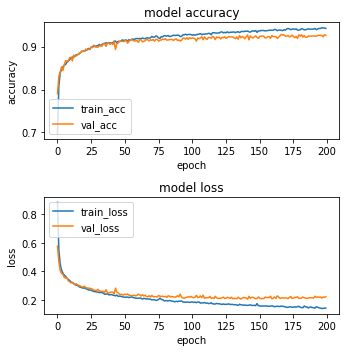

In [164]:
# plotting the metrics
fig = plt.figure()
plt.figure(figsize=(5, 5))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='lower left')
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
#plt.ylim([0, 1.5])
plt.tight_layout()

In [2]:
y_test = modelIET.predict(X_test)
y=enc.inverse_transform(y_test)
y=np.array(pd.DataFrame(y)[0]).astype(int)
y.shape

NameError: name 'modelIET' is not defined

In [166]:
print("IM SAVING")
## Save results to submission file
pred_df = pd.DataFrame(y, columns=['label'])
pred_df.to_csv("submission.csv", index=True, index_label='Id')

IM SAVING


In [171]:
pred_df

,label
0,2.0
1,0.0
2,0.0
3,3.0
4,0.0
...,...
10740,0.0
10741,0.0
10742,3.0
10743,0.0
